# Capstone Project: Neighborhoods of Doha

##### by Alexander Lotyukhov

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem 


In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Georgian restaurant** in **Doha**, Qatar.

There are a lot of restaurants in Doha, so we will try to detect locations that are not already crowded with restaurants. We are also particularly interested in **areas with no Georgian restaurants around**. We would also prefer most populated locations, assuming that first two conditions are met.

We will use our data science powers to generate a few most promising neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on problem definition, factors that will influence our decision are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of Georgian restaurants in the neighborhood, if any
* population of neighborhood

We decided to use existing zones and districts in Doha as neighborhoods for this project.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using Wikipedia and OpenStreetMap Nominatim API data
* number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API
* Population of each neighborhood will be obtained from Wikipedia

In [2]:
!pip install pandas
import pandas as pd

!pip install numpy
import numpy as np

#!conda install -c conda-forge geopy --yes  
!pip install geopy  
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes
!pip install folium
import folium # map rendering library

import requests

!pip install lxml

from bs4 import BeautifulSoup
import requests
import bs4

#!pip install sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
#!pip install matplotlib
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#pd.options.display.max_columns = None
#pd.options.display.max_rows = None
print('Modules loaded')

Modules loaded


### Neighborhood Candidates
Doha is split into zones. Each zone futher more could be split into districs. 
Let's collect Doha neighborhoods data from https://en.wikipedia.org/wiki/Zones_of_Qatar and add latitude & longitude information for next processing. 
We will use with read_html to get disctricts.

In [3]:
url = ("https://en.wikipedia.org/wiki/Zones_of_Qatar")
# read url
Demo_data = pd.read_html(url, header=0)
frames = [Demo_data[2], Demo_data[3], Demo_data[4],Demo_data[5],Demo_data[6],Demo_data[7]]
DohZones = pd.concat(frames)
DohZones.head()

,Zone no.,Districts,Area (km²),Population (2015)
0,1,Al Jasrah,0.4,240 (2010)[6]
1,2,Al Bidda,NaN,35 (2010)[6]
2,3,Fereej Mohamed Bin Jasim Mushayrib,NaN,"4,886 (2010)[6]"
3,4,Mushayrib,0.3,9791
4,5,Al Najada Barahat Al Jufairi Fereej Al Asmakh,0.2,2086


As we can see Pandas read_html method doesn't seaparate districts. Let's use beautifulsoup4 to parse html

In [4]:
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
tbl = soup.find_all('table',{'class':'wikitable'})
print('There are {} tables on the page'.format(len(tbl)))

There are 9 tables on the page


Let's parse html page and set area, population, latitude, longitude for each zone and district combination.
Below code will try to get latitude, longitude for each ditrict from Wikipedia itself following disctrict link.

Here is the example:

| Zone no. | Districts | Area (km²) | Population (2015) |
| ----------- | ----------- | ----------- | ----------- |
| 5 | [Al Najada](https://en.wikipedia.org/wiki/Al_Najada) |  0.2 | 2,086 |
|   | [Barahat Al Jufairi](https://en.wikipedia.org/wiki/Barahat_Al_Jufairi) |  | |
|   | Fereej Al Asmakh | | |

For this table code will follow link [Al Najada](https://en.wikipedia.org/wiki/Al_Najada) and link [Barahat Al Jufairi](https://en.wikipedia.org/wiki/Barahat_Al_Jufairi) and will try to get latitude, longitude from corresponding pages https://en.wikipedia.org/wiki/Al_Najada and https://en.wikipedia.org/wiki/Barahat_Al_Jufairi


In [5]:
zone = 0
districts = 0
area = 0
population = 0
districts_d={}
# creat a new Dataframe
columnlabel = ['Zone','District','Area','Population','Latitude','Longitude','P']
doha = pd.DataFrame(columns = columnlabel)
print('There are {} tables on the page'.format(len(tbl)))

#go through all tables and parse only ones that belong to Ad Dawhah, Al Rayyan and Al Daayen municipalities 
for j in range(1,len(tbl)): 
    if j in (4,5,6,7,8):
        # skip Municipalities that we are not interested in
        continue
    for tr in tbl[j].find_all('tr'):
        i = 0
        p = 0
        for td in tr.find_all('td'):
            if i == 0:
                zone = td.text
                i = i + 1
            elif i == 1:
                districts_d={}
                for link in td.contents: 
                    if link not in (' ','<br/>','') and link.name != 'br':
                        if isinstance(link, bs4.element.NavigableString):
                            districts_d[link]=[0,0]
                        else:
                            if link.has_attr('href') and link['href'][0:6]=='/wiki/':
                                coord_url = "https://en.wikipedia.org" + link['href']
                                page = requests.get(coord_url)
                                soup1 = BeautifulSoup(page.content, 'html.parser')
                                coord=soup1.find("span", {"class":"geo"}).text.split(";")
                                districts_d[link.text]=coord
                            else:
                                districts_d[link.text]=[0,0]
                    districts = td.text.strip()
                i = i + 1
            elif i == 2: 
                area = td.text
                i = i + 1
            elif i == 3: 
                population = td.text
                i = i + 1
        for districts, coords in districts_d.items():
            doha = doha.append({'Zone': zone,'District': districts.strip(),'Area': area, 'Population':population,'Latitude':coords[0],'Longitude':coords[1],'P':len(districts_d)},ignore_index=True)

#add Pearl disctrict as it is a new big district with big population.  
doha = doha.append({'Zone': '66','District': 'Pearl','Area': '26.1', 'Population':'27,000','Latitude':25.371808,'Longitude': 51.551392,'P':1},ignore_index=True)
doha.head()

There are 9 tables on the page


,Zone,District,Area,Population,Latitude,Longitude,P
0,1,Al Jasrah,0.4,240 (2010)[6]\n,25.28611,51.53417,1
1,2,Al Bidda,N/A,35 (2010)[6]\n,25.29972,51.51972,1
2,3,Fereej Mohamed Bin Jasim,N/A,"4,886 (2010)[6]\n",0,0,2
3,3,Mushayrib,N/A,"4,886 (2010)[6]\n",25.283,51.517,2
4,4,Mushayrib,0.3,"9,791\n",25.283,51.517,1


Now let's clean dataframe and remove unnecessary information, also fill N/A values

In [6]:
DohZones=doha

In [7]:
DohZones=DohZones.drop(DohZones[DohZones['Zone']=='Municipality'].index)
DohZones=DohZones.drop(DohZones[DohZones['Zone']=='Total'].index)
DohZones['Population'] = DohZones['Population'].astype(str)
DohZones['Population']=DohZones['Population'].str.replace(r' \(\d*\)\[\d*\]','',regex=True)
DohZones['Population']=DohZones['Population'].str.replace(',','',regex=True)
DohZones['Population']=DohZones['Population'].str.replace('\n','',regex=True)
DohZones['Population']=DohZones['Population'].fillna(0)
DohZones['Area']=DohZones['Area'].fillna(1)
DohZones['Area']=DohZones['Area'].str.replace('N/A','1',regex=True)
DohZones['Area']=DohZones['Area'].astype(float)

Here is now districts in zone 55 looks like, P here is number of disctricts in the zone.

In [8]:
DohZones[DohZones['Zone']=='55']

,Zone,District,Area,Population,Latitude,Longitude,P
96,55,Fereej Al Soudan,82.4,283675,0,0,10
97,55,Al Waab,82.4,283675,25.25889,51.46750,10
98,55,Al Aziziya,82.4,283675,25.25556,51.43111,10
99,55,New Fereej Al Ghanim,82.4,283675,25.24306,51.45250,10
100,55,Fereej Al Murra,82.4,283675,25.232157,51.436546,10
101,55,Fereej Al Manaseer,82.4,283675,25.248926,51.428451,10
102,55,Bu Sidra,82.4,283675,25.2367,51.4054,10
103,55,Muaither,82.4,283675,25.26611,51.42083,10
104,55,Al Sailiya,82.4,283675,25.21889,51.37972,10
105,55,Al Mearad,82.4,283675,25.2500,51.3732,10


Let's get average area and popopulation for each district

In [9]:
DohZones['Population']=DohZones['Population'].astype(int)/DohZones['P']
DohZones['Area']=DohZones['Area']/DohZones['P']
DohZones[DohZones['Zone']=='54']

,Zone,District,Area,Population,Latitude,Longitude,P
90,54,Fereej Al Amir,3.01667,4098.83,25.287072,51.472931,6
91,54,Luaib,3.01667,4098.83,0,0,6
92,54,Muraikh,3.01667,4098.83,25.28333,51.45000,6
93,54,Baaya,3.01667,4098.83,25.26750,51.44250,6
94,54,Mehairja,3.01667,4098.83,25.2691,51.4598,6
95,54,Fereej Al Soudan,3.01667,4098.83,25.27389,51.47889,6


Next let's adjust data types for numeric values and calculate radius that we will use in *Foursquare API*

In [10]:
DohZones['Zone'] = DohZones['Zone'].astype(int)
DohZones['Latitude'] = DohZones['Latitude'].astype(float)
DohZones['Longitude'] = DohZones['Longitude'].astype(float)
DohZones.reset_index(drop=True)
DohZones=DohZones.sort_values('Zone', ascending=False).reset_index(drop=True)
DohZones['Area'] = DohZones['Area'].astype(float)
DohZones['radius']=0.0
DohZones['radius']=round(np.sqrt(DohZones['Area']/3.141592)*500.0)

In next step we will set coordinates for zones and districts that didn't have them in *wiki*. We will do that by using **Nominatim** geocoder from **GeoPy**. 

*Note we have to use this complicated method to get coordinates because Nominatim was not able to get coordinates for neither all zones nor all districts. This was found during data clearing excersise.*

In [11]:
geolocator = Nominatim(user_agent="doha_explorer")

for i in range(len(DohZones)):
    address = 'Zone ' + str(DohZones['Zone'][i]) +', Doha, Qatar'
    if DohZones['Latitude'][i]==0: 
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        DohZones.at[i, 'Latitude']=latitude
        DohZones.at[i, 'Longitude']=longitude
print('Dataframe updated')

Dataframe updated


Let's define Neighborhood as combination of zone and district

In [12]:
DohZones['Neighborhood']=DohZones["District"]+',z'+DohZones['Zone'].astype(str)

In [13]:
DohZones.head()
#DohZones[DohZones['Zone']==66]

,Zone,District,Area,Population,Latitude,Longitude,P,radius,Neighborhood
0,97,Sawda Natheel,566.700,100,24.56833,51.06833,1,6715.0,"Sawda Natheel,z97"
1,96,Abu Samra,801.700,984,24.73806,50.89528,1,7987.0,"Abu Samra,z96"
2,83,Al Karaana,554.300,2614,25.01111,51.04444,1,6642.0,"Al Karaana,z83"
3,81,Mebaireek,160.500,12483,25.19000,51.38000,1,3574.0,"Mebaireek,z81"
4,70,Rawdat Al Hamama,19.925,4416.75,25.44611,51.46861,12,1259.0,"Rawdat Al Hamama,z70"


Let's visualize defined neighborhoods

In [14]:
geolocator = Nominatim(user_agent="doha_explorer")

address = 'Doha, Qatar'
print(address)
location = geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
map_doha = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, districts in zip(DohZones['Latitude'], DohZones['Longitude'], DohZones['Neighborhood']):
    label = '{}'.format(districts)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_doha)  
    
map_doha

Doha, Qatar


Let's see if coordinates and neighborhood radius were set correctly or we need to do some adjustments

In [15]:
geolocator = Nominatim(user_agent="doha_explorer")

address = 'Doha, Qatar'
print(address)
location = geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
map_doha = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, zone, districts, rds in zip(DohZones['Latitude'], DohZones['Longitude'], DohZones['Zone'], DohZones['Neighborhood'],DohZones['radius']):
    label = '{}, {}'.format(districts, zone)
    label = folium.Popup(label, parse_html=True)
    #folium.CircleMarker(
    folium.Circle(
        [lat, lng],
        radius=rds+50,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_doha)  
    
map_doha

Doha, Qatar


As we can see some coordinates and selection radius are far off actual districts. Let's fix it by information acquired manually from GoogleMaps

In [16]:
#manual fix for coordinates and radius
DohZones.loc[DohZones[DohZones['Neighborhood']=='Doha International Airport,z49'].index,['Latitude','Longitude']] =[25.273752,51.611152]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Lusail,z70'].index,['Latitude','Longitude']] =[25.490588, 51.478683]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Zone 50,z50'].index,['Latitude','Longitude']] =[25.216109,51.552390]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Zone 58,z58'].index,['Latitude','Longitude']] =[25.244730, 51.477331]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Jeryan Jenaihat,z70'].index,['Latitude','Longitude']] =[25.420122, 51.432377]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Old Al Rayyan,z52'].index,['Latitude','Longitude']] =[25.299757, 51.450615]
DohZones.loc[DohZones[DohZones['Neighborhood']=='New Al Rayyan,z53'].index,['Latitude','Longitude','radius']] =[25.289875, 51.421327,850]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Muaither,z53'].index,['Latitude','Longitude','radius']] =[25.276381, 51.415973,850]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Muaither,z55'].index,['Latitude','Longitude','radius']] =[25.253289, 51.414557,1100]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Fereej Al Manaseer,z55'].index,['radius']] =[250]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Al Aziziya,z55'].index,['Latitude','Longitude','radius']] =[25.248000, 51.448417,1250]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Fereej Al Murra,z55'].index,['Latitude','Longitude','radius']] =[25.233026, 51.436336,410]
DohZones.loc[DohZones[DohZones['Neighborhood']=='New Fereej Al Ghanim,z55'].index,['Latitude','Longitude','radius']] =[25.236520, 51.442602,200]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Bani Hajer,z51'].index,['Latitude','Longitude','radius']] =[25.314677, 51.402261,600]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Al Wajbah,z53'].index,['Latitude','Longitude','radius']] =[25.289895, 51.364892,2800]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Al Mearad,z55'].index,['Latitude','Longitude']] =[25.240383, 51.376898]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Mebaireek,z81'].index,['Latitude','Longitude','radius']] =[25.178967, 51.377842,1350]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Industrial Area,z57'].index,['Latitude','Longitude','radius']] =[25.185307, 51.427763,2750]
DohZones.loc[DohZones[DohZones['Neighborhood']=='New Fereej Al Khulaifat,z56'].index,['Latitude','Longitude','radius']] =[25.246088, 51.510380,200]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Al Mamoura,z56'].index,['Latitude','Longitude','radius']] =[25.249591, 51.500284,920]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Fereej Al Asiri,z56'].index,['radius']] =[400]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Bu Samra,z56'].index,['Latitude','Longitude']] =[25.205847, 51.503187]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Luaib,z54'].index,['Latitude','Longitude']] =[25.284809, 51.460454]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Abu Hamour,z56'].index,['Latitude','Longitude']] =[25.235052, 51.491256]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Ain Khaled,z56'].index,['Latitude','Longitude','radius']] =[25.229491, 51.463307,1400]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Fereej Al Nasr,z39'].index,['Latitude','Longitude','radius']] =[25.270101, 51.497199,356]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Al Sadd,z39'].index,['Latitude','Longitude','radius']] =[25.277484, 51.503846,400]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Fereej Bin Mahmoud,z23'].index,['Latitude','Longitude','radius']] =[25.280768, 51.512295,400]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Fereej Bin Mahmoud,z22'].index,['Latitude','Longitude','radius']] =[25.287122, 51.511415,300]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Al Sadd,z38'].index,['Latitude','Longitude']] =[25.286365, 51.500740]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Fereej Mohamed Bin Jasim,z3'].index,['Latitude','Longitude','radius']] =[25.285613, 51.529236,100]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Mushayrib,z3'].index,['Latitude','Longitude','radius']] =[25.285904, 51.527176,250]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Mushayrib,z4'].index,['Latitude','Longitude']] =[25.282140, 51.529569]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Al Najada,z5'].index,['Latitude','Longitude']] =[25.285235, 51.533013]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Al Hilal,z42'].index,['Latitude','Longitude']] =[25.260844, 51.547282]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Al Jasrah,z1'].index,['Latitude','Longitude']] =[25.289173, 51.532337]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Rumeilah,z11'].index,['Latitude','Longitude']] =[25.300803, 51.512017]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Fereej Abdel Aziz,z14'].index,['Latitude','Longitude','radius']] =[25.277997, 51.524087,300]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Old Al Ghanim,z6'].index,['Latitude','Longitude']] =[25.284109, 51.537530]
DohZones.loc[DohZones[DohZones['Neighborhood']=='As Salatah,z18'].index,['Latitude','Longitude']] =[25.289551, 51.546886]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Al Rufaa,z17'].index,['Latitude','Longitude']] =[25.284948, 51.542155]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Fereej Al Asmakh,z5'].index,['Latitude','Longitude']] =[25.280941, 51.532735]
DohZones.loc[DohZones[DohZones['Neighborhood']=='Nuaija,z41'].index,['Latitude','Longitude','radius']] =[25.258228, 51.530589,630]
DohZones.loc[DohZones[DohZones['Neighborhood']=='New Salatah,z40'].index,['Latitude','Longitude','radius']] =[25.261993, 51.511202,700]
print('Data fixed')


Data fixed


Let's see how it worked

In [17]:
geolocator = Nominatim(user_agent="doha_explorer")

address = 'Doha, Qatar'
print(address)
location = geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
map_doha = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, zone, districts, rds in zip(DohZones['Latitude'], DohZones['Longitude'], DohZones['Zone'], DohZones['Neighborhood'],DohZones['radius']):
    label = '{}, {}'.format(districts, zone)
    label = folium.Popup(label, parse_html=True)
    #folium.CircleMarker(
    folium.Circle(
        [lat, lng],
        radius=rds+50,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_doha)  
    
map_doha

Doha, Qatar


### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on venues in each neighborhood.


In [18]:
def getNearbyVenues(names, latitudes, longitudes, r, radius):
    
    venues_list=[]
    for name, lat, lng, area in zip(names, latitudes, longitudes, r):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            area+50, 
            LIMIT
            )
   
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
# The code was removed by Watson Studio for sharing.

Let's get venues for each neighborhood

In [20]:
Doha_venues_ = getNearbyVenues(names=DohZones['Neighborhood'],
                                latitudes=DohZones['Latitude'],
                                longitudes=DohZones['Longitude'],
                                r=DohZones['radius'],
                                radius=Radius
                                  )

Let's see how many velues we got for each neighborhood

In [21]:
#pd.options.display.max_rows = None
Doha_venues_.groupby('Neighborhood').count().sort_values('Venue',ascending=False)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Pearl,z66",100,100,100,100,100,100
"Al Dafna,z61",73,73,73,73,73,73
"Al Aziziya,z55",53,53,53,53,53,53
"Al Ebb,z70",49,49,49,49,49,49
"Doha International Airport,z49",48,48,48,48,48,48
"Fereej Al Soudan,z55",42,42,42,42,42,42
"Al Sadd,z38",39,39,39,39,39,39
"Doha International Airport,z48",38,38,38,38,38,38
"Al Gharrafa,z51",36,36,36,36,36,36


Let's see if any of these are actually **Georgian restaurant**

In [22]:
Doha_venues_[Doha_venues_['Venue Category']=='Caucasian Restaurant'].count()

Neighborhood              0
Neighborhood Latitude     0
Neighborhood Longitude    0
Venue                     0
Venue Latitude            0
Venue Longitude           0
Venue Category            0
dtype: int64

This is unexpected  - there no Georgian restorants in town.

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations for a new Georgian restaurant !

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Doha that have low restaurant density. 

In first step we have collected the required data about neighborhoods of Doha and venues within there neighborhoods using **Foursquare API**

In next and final step we will focus on differencies and simularities of these neighborhoods by grouping them into clusters (using **k-means clustering**) and analyzing each cluster individually. 
We will present map of all neighborhoods and clusters that they form to identify general zones / district which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

### Data analysis  <a name="analysis"></a>

Let's create venues frequency dataset.

In [23]:
# one hot encoding
Doha_onehot = pd.get_dummies(Doha_venues_[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Doha_onehot['Neighborhood'] = Doha_venues_['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [Doha_onehot.columns[-1]] + list(Doha_onehot.columns[:-1])
Doha_onehot = Doha_onehot[fixed_columns]

Doha_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,Aquarium,...,Tex-Mex Restaurant,Thai Restaurant,Theater,Toy / Game Store,Turkish Restaurant,Vegetarian / Vegan Restaurant,Volleyball Court,Wings Joint,Women's Store,Zoo
0,"Sawda Natheel,z97",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Abu Samra,z96",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Abu Samra,z96",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Abu Samra,z96",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Abu Samra,z96",0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 and normalize it using *mean()* method

In [24]:
Doha_grouped = Doha_onehot.groupby('Neighborhood').mean().reset_index()
Doha_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,Aquarium,...,Tex-Mex Restaurant,Thai Restaurant,Theater,Toy / Game Store,Turkish Restaurant,Vegetarian / Vegan Restaurant,Volleyball Court,Wings Joint,Women's Store,Zoo
0,"Abu Hamour,z56",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.028571,0.0,0.0,0.0,0.0,0.0
1,"Abu Samra,z96",0.0,0.000000,0.0,0.2,0.0,0.0,0.0,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,"Ad Dawhah al Jadidah,z15",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0
3,"Ain Khaled,z56",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,0.0
4,"Al Aziziya,z55",0.0,0.018868,0.0,0.0,0.0,0.0,0.0,0.037736,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


Let's get most common venues for each neighborhood. We will get only top 3 venues as for most of neighborhoods total number of venues is very small

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Doha_grouped['Neighborhood']

for ind in np.arange(Doha_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Doha_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Abu Hamour,z56",Café,Coffee Shop,Fast Food Restaurant,Middle Eastern Restaurant
1,"Abu Samra,z96",Border Crossing,Airport,Beach,American Restaurant
2,"Ad Dawhah al Jadidah,z15",Turkish Restaurant,Hotel,Bakery,Café
3,"Ain Khaled,z56",Coffee Shop,Asian Restaurant,Indian Chinese Restaurant,Chinese Restaurant
4,"Al Aziziya,z55",Café,Asian Restaurant,Coffee Shop,Cafeteria


In [27]:
Doha_grouped_clust = Doha_grouped.drop('Neighborhood', 1)

Our dataset is ready! Now we need to decided number of clusters we would like to split our dataset into. In otder to do that we will use **Elbow method**. If it will not be enough to decide we will also use **Average silhouette score**.

In [29]:
Sum_of_squared_distances = []
sil = []
K = range(2,20)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(Doha_grouped_clust)
    #km = KMeans(n_clusters=k).fit(Doha_grouped_clust)
    Sum_of_squared_distances.append(km.inertia_)
    sil.append(silhouette_score(Doha_grouped_clust, km.labels_, metric = 'chebyshev')) 

Let's see results for both methods

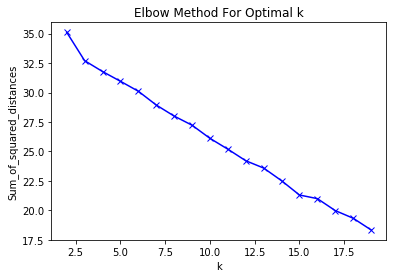

In [30]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Elbow method doesn't give us decisive number, let's see average silhouette score

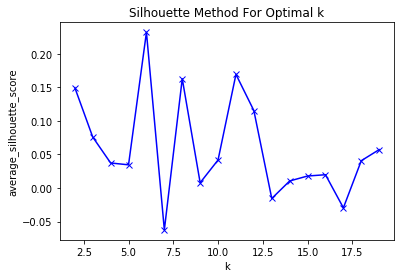

In [31]:
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('average_silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

We get maximum of average silhouette score at 9 clusters

In [32]:
# set number of clusters
kclusters =6
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters).fit(Doha_grouped_clust)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4],
      dtype=int32)

In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [34]:
#neighborhoods_venues_sorted
#DohZones
Doha_grouped_clust.head()

,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,...,Tex-Mex Restaurant,Thai Restaurant,Theater,Toy / Game Store,Turkish Restaurant,Vegetarian / Vegan Restaurant,Volleyball Court,Wings Joint,Women's Store,Zoo
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.028571,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.2,0.0,0.0,0.0,0.200000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,0.0
4,0.0,0.018868,0.0,0.0,0.0,0.0,0.0,0.037736,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [35]:
Doha_merged=DohZones
# merge DohZones with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
Doha_merged = Doha_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Doha_merged.head()

,Zone,District,Area,Population,Latitude,Longitude,P,radius,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,97,Sawda Natheel,566.700,100,24.568330,51.068330,1,6715.0,"Sawda Natheel,z97",4.0,Campground,Zoo,Department Store,Falafel Restaurant
1,96,Abu Samra,801.700,984,24.738060,50.895280,1,7987.0,"Abu Samra,z96",4.0,Border Crossing,Airport,Beach,American Restaurant
2,83,Al Karaana,554.300,2614,25.011110,51.044440,1,6642.0,"Al Karaana,z83",4.0,Airport Service,Lake,Airport,Summer Camp
3,81,Mebaireek,160.500,12483,25.178967,51.377842,1,1350.0,"Mebaireek,z81",2.0,Market,Restaurant,Department Store,Falafel Restaurant
4,70,Rawdat Al Hamama,19.925,4416.75,25.446110,51.468610,12,1259.0,"Rawdat Al Hamama,z70",1.0,Diner,Zoo,Clothing Store,Farm


Let's see if we have neighborhoods that were not clustered because they have no venues at all

In [36]:
Doha_merged[Doha_merged['Cluster Labels'].isnull()]

,Zone,District,Area,Population,Latitude,Longitude,P,radius,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
7,70,Al Kheesa,19.925000,4416.75,25.417500,51.458890,12,1259.0,"Al Kheesa,z70",NaN,NaN,NaN,NaN,NaN
11,70,Wadi Lusail,19.925000,4416.75,25.495510,51.432371,12,1259.0,"Wadi Lusail,z70",NaN,NaN,NaN,NaN,NaN
12,70,Lusail,19.925000,4416.75,25.490588,51.478683,12,1259.0,"Lusail,z70",NaN,NaN,NaN,NaN,NaN
13,70,Umm Qarn,19.925000,4416.75,25.577780,51.450000,12,1259.0,"Umm Qarn,z70",NaN,NaN,NaN,NaN,NaN
16,69,Jabal Thuaileb,10.220000,267.6,25.412220,51.518330,5,902.0,"Jabal Thuaileb,z69",NaN,NaN,NaN,NaN,NaN
19,69,Lusail,10.220000,267.6,25.500000,51.483000,5,902.0,"Lusail,z69",NaN,NaN,NaN,NaN,NaN
36,56,Mesaimeer,8.728571,18418.3,25.190000,51.489720,7,833.0,"Mesaimeer,z56",NaN,NaN,NaN,NaN,NaN
42,56,New Fereej Al Khulaifat,8.728571,18418.3,25.246088,51.510380,7,200.0,"New Fereej Al Khulaifat,z56",NaN,NaN,NaN,NaN,NaN
56,54,Muraikh,3.016667,4098.83,25.283330,51.450000,6,490.0,"Muraikh,z54",NaN,NaN,NaN,NaN,NaN
69,51,Al Seej,11.557143,8003.86,25.321845,51.374191,7,959.0,"Al Seej,z51",NaN,NaN,NaN,NaN,NaN


Let's visualize these on the map

In [37]:
geolocator = Nominatim(user_agent="doha_explorer")

address = 'Doha, Qatar'
print(address)
location = geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
map_doha = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, districts in zip(Doha_merged[Doha_merged['Cluster Labels'].isnull()]['Latitude'], Doha_merged[Doha_merged['Cluster Labels'].isnull()]['Longitude'], Doha_merged[Doha_merged['Cluster Labels'].isnull()]['Neighborhood']):
    label = '{}'.format(districts)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_doha)  
    
map_doha

Doha, Qatar


We will note these neighborhoods for conclusion section and will continue with clusters analysis without them

In [38]:
Doha_merged=Doha_merged.drop(Doha_merged[Doha_merged['Cluster Labels'].isnull()].index)
Doha_merged.dropna(inplace=True)
Doha_merged['Cluster Labels'] = Doha_merged['Cluster Labels'].astype(int)

## Results and Discussion <a name="results"></a>

Let's visualise clusters that and see each one in details

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters=6

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Doha_merged['Latitude'], Doha_merged['Longitude'], Doha_merged['Neighborhood'], Doha_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-3],
        fill=True,
        fill_color=rainbow[cluster-3],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 1

In [40]:
Doha_merged.loc[Doha_merged['Cluster Labels'] == 0, Doha_merged.columns[[1] + [3] + list(range(6, Doha_merged.shape[1]))]]

,District,Population,P,radius,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
48,Fereej Al Murra,28367.5,10,410.0,"Fereej Al Murra,z55",0,Department Store,Asian Restaurant,Cafeteria,Farm
49,Fereej Al Manaseer,28367.5,10,250.0,"Fereej Al Manaseer,z55",0,Athletics & Sports,Zoo,Dessert Shop,Farm
89,Hamad Medical City,8707,3,258.0,"Hamad Medical City,z37",0,Asian Restaurant,Athletics & Sports,Pool Hall,Cafeteria
110,Wadi Al Sail,240,1,322.0,"Wadi Al Sail,z20",0,Pharmacy,Asian Restaurant,Boutique,Cafeteria
125,Fereej Al Asmakh,695.333,3,73.0,"Fereej Al Asmakh,z5",0,Asian Restaurant,Indonesian Restaurant,Zoo,Farm


#### Cluster 2

In [41]:
Doha_merged.loc[Doha_merged['Cluster Labels'] == 1, Doha_merged.columns[[1] + [3] + list(range(6, Doha_merged.shape[1]))]]

,District,Population,P,radius,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
4,Rawdat Al Hamama,4416.75,12,1259.0,"Rawdat Al Hamama,z70",1,Diner,Zoo,Clothing Store,Farm


#### Cluster 3

In [42]:
Doha_merged.loc[Doha_merged['Cluster Labels'] == 2, Doha_merged.columns[[1] + [3] + list(range(6, Doha_merged.shape[1]))]]

,District,Population,P,radius,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
3,Mebaireek,12483,1,1350.0,"Mebaireek,z81",2,Market,Restaurant,Department Store,Falafel Restaurant
23,Al Tarfa,1840.33,3,507.0,"Al Tarfa,z68",2,Coffee Shop,Food Court,Zoo,Dessert Shop
30,Lejbailat,4151,1,334.0,"Lejbailat,z64",2,Fast Food Restaurant,Coffee Shop,Hotel,Palace
54,Mehairja,4098.83,6,490.0,"Mehairja,z54",2,Hotel,Park,Zoo,Department Store
55,Baaya,4098.83,6,490.0,"Baaya,z54",2,Athletics & Sports,Hotel,Gym / Fitness Center,Turkish Restaurant
74,Zone 50,1137,1,778.0,"Zone 50,z50",2,Gym / Fitness Center,Restaurant,Zoo,Department Store
95,Al Markhiya,6242,1,464.0,"Al Markhiya,z33",2,Fast Food Restaurant,Flower Shop,Hotel,Café
106,Rawdat Al Khail,18200,1,368.0,"Rawdat Al Khail,z24",2,Indian Restaurant,Gym,Hotel,Shop & Service
107,Fereej Bin Mahmoud,17086,1,400.0,"Fereej Bin Mahmoud,z23",2,Hotel,Thai Restaurant,Korean Restaurant,Food & Drink Shop
108,Fereej Bin Mahmoud,11241,1,300.0,"Fereej Bin Mahmoud,z22",2,Hotel,Fast Food Restaurant,Korean Restaurant,Gym / Fitness Center


#### Cluster 4

In [43]:
Doha_merged.loc[Doha_merged['Cluster Labels'] == 3, Doha_merged.columns[[1] + [3] + list(range(6, Doha_merged.shape[1]))]]

,District,Population,P,radius,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
103,Najma,28228,1,296.0,"Najma,z26",3,Bed & Breakfast,Fast Food Restaurant,Farm,Falafel Restaurant


#### Cluster 5

In [44]:
Doha_merged.loc[Doha_merged['Cluster Labels'] == 4, Doha_merged.columns[[1] + [3] + list(range(6, Doha_merged.shape[1]))]]

,District,Population,P,radius,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Sawda Natheel,100,1,6715.0,"Sawda Natheel,z97",4,Campground,Zoo,Department Store,Falafel Restaurant
1,Abu Samra,984,1,7987.0,"Abu Samra,z96",4,Border Crossing,Airport,Beach,American Restaurant
2,Al Karaana,2614,1,6642.0,"Al Karaana,z83",4,Airport Service,Lake,Airport,Summer Camp
5,Leabaib,4416.75,12,1259.0,"Leabaib,z70",4,Coffee Shop,Grocery Store,Athletics & Sports,Intersection
6,Jeryan Jenaihat,4416.75,12,1259.0,"Jeryan Jenaihat,z70",4,Beach,Construction & Landscaping,Fast Food Restaurant,Zoo
8,Al Ebb,4416.75,12,1259.0,"Al Ebb,z70",4,Coffee Shop,Ice Cream Shop,Clothing Store,Italian Restaurant
9,Al Sakhama,4416.75,12,1259.0,"Al Sakhama,z70",4,Farm,Soccer Stadium,Boarding House,Dessert Shop
10,Al Masrouhiya,4416.75,12,1259.0,"Al Masrouhiya,z70",4,Construction & Landscaping,Campground,Art Gallery,Zoo
14,Al Daayen,4416.75,12,1259.0,"Al Daayen,z70",4,Beach,Turkish Restaurant,Cafeteria,Zoo
15,Wadi Al Wasaah,4416.75,12,1259.0,"Wadi Al Wasaah,z70",4,Farm,Boat or Ferry,Cafeteria,Burger Joint


#### Cluster 6

In [46]:
Doha_merged.loc[Doha_merged['Cluster Labels'] == 5, Doha_merged.columns[[1] + [3] + list(range(6, Doha_merged.shape[1]))]]

,District,Population,P,radius,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
109,Rumeilah,1590,1,252.0,"Rumeilah,z21",5,Café,Zoo,Department Store,Falafel Restaurant
115,Al Rufaa,3013,2,126.0,"Al Rufaa,z17",5,Café,Zoo,Department Store,Falafel Restaurant
126,Barahat Al Jufairi,695.333,3,73.0,"Barahat Al Jufairi,z5",5,Café,Zoo,Department Store,Falafel Restaurant


Our analysis shows that even thought there are plenty of venues in Doha there are still a lot of areas that could be used to open new **Georgian restaurant**. 

- Starting with neighborhoods with no venues:  We could see that there is big opportunity in Zone 70 which is constantly developing and have growing local population. Also we can see that Mushayrib in Zone 13 which is located in downtown Doha would be a great opportunity due to possible high tourist traffic
- Cluster 1 shows good potential as it has good volume of population on Zone 55
- Cluster 3 would be a good opportunity result as it has big local population as well as hotels as most common venue (indicating a lot of tourists). Note that Mushayrib districts are part of this cluster.
- Cluster 4 would be a great opportunity. There are 28 thousand population with almost no restaurants. I would recommend extra analysis on income before taking decision

Summarizing above data I would recommend **Mushayrib** district in downtown Doha as a place to be considered to open **Georgian restaurant** 


## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Doha districts with low number of restaurants in order to help stakeholders in narrowing down the search for optimal location for a new Georgian restaurant. By using k-means cluster algorithm Doha districts were separated into nine different clusters based on venues available through Foursquare API. Presence of 10th cluster (districts with no venues) shows that there might be not enough data in Foursquare API for Doha in particularly and final decision on optimal restaurant location should be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like housing pricing, income, pedestrian density, number of tourists, hotel occupancy,  schools availability, traffic density, social and economic dynamics of every districts, etc.